In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import cv2
import numpy as np
import imutils
import tensorflow as tf
from sklearn.model_selection import train_test_split
import random
from skimage import io
import datetime

In [6]:
df = pd.read_csv(r"E:\git_repos\Brain_Tum_segmentation\archive\kaggle_3m\data.csv")
df.head()

,Patient,RNASeqCluster,MethylationCluster,miRNACluster,CNCluster,RPPACluster,OncosignCluster,COCCluster,histological_type,neoplasm_histologic_grade,tumor_tissue_site,laterality,tumor_location,gender,age_at_initial_pathologic,race,ethnicity,death01
0,TCGA_CS_4941,2.0,4.0,2,2.0,NaN,3.0,2,1.0,2.0,1.0,3.0,2.0,2.0,67.0,3.0,2.0,1.0
1,TCGA_CS_4942,1.0,5.0,2,1.0,1.0,2.0,1,1.0,2.0,1.0,3.0,2.0,1.0,44.0,2.0,NaN,1.0
2,TCGA_CS_4943,1.0,5.0,2,1.0,2.0,2.0,1,1.0,2.0,1.0,1.0,2.0,2.0,37.0,3.0,NaN,0.0
3,TCGA_CS_4944,NaN,5.0,2,1.0,2.0,1.0,1,1.0,1.0,1.0,3.0,6.0,2.0,50.0,3.0,NaN,0.0
4,TCGA_CS_5393,4.0,5.0,2,1.0,2.0,3.0,1,1.0,2.0,1.0,1.0,6.0,2.0,39.0,3.0,NaN,0.0


In [8]:
PATH = r"E:\git_repos\Brain_Tum_segmentation\archive\kaggle_3m"
list_dir = []
for dir in os.listdir(PATH):
    dir = PATH + '/' + dir
    if os.path.isdir(dir):
        list_dir.append(dir)

In [9]:
MRI_image = []
MRI_mask = []
for i in range(len(list_dir)):
    directory_path = list_dir[i]
    for mask in os.listdir(directory_path):
        if '_mask' in mask:
            MRI_mask.append(directory_path + '/' + mask)
            mask = mask.replace('_mask','')
            MRI_image.append(directory_path + '/' + mask)



In [10]:
# Checking is all the images are proper files or not
for file in MRI_image:
    if not  os.path.isfile(file):
        print("error")

for file in MRI_mask:
    if not  os.path.isfile(file):
        print("error")

In [11]:
images_df = pd.DataFrame(data = zip(MRI_image,MRI_mask),columns= ['MRI_image', 'MRI_mask'])
images_df.head()

,MRI_image,MRI_mask
0,E:\git_repos\Brain_Tum_segmentation\archive\ka...,E:\git_repos\Brain_Tum_segmentation\archive\ka...
1,E:\git_repos\Brain_Tum_segmentation\archive\ka...,E:\git_repos\Brain_Tum_segmentation\archive\ka...
2,E:\git_repos\Brain_Tum_segmentation\archive\ka...,E:\git_repos\Brain_Tum_segmentation\archive\ka...
3,E:\git_repos\Brain_Tum_segmentation\archive\ka...,E:\git_repos\Brain_Tum_segmentation\archive\ka...
4,E:\git_repos\Brain_Tum_segmentation\archive\ka...,E:\git_repos\Brain_Tum_segmentation\archive\ka...


In [12]:
images_df.shape

(3929, 2)

In total we have 3929 images and their respective masks.

##### Preprocessing Checks

In [13]:
def plot_pair(image,mask):
    """
    Inputs: image and mask 
    Outputs: plot both image and plot side by side
    """
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7, 5))
    axes[0].imshow(image)
    axes[0].get_xaxis().set_visible(False)
    axes[0].get_yaxis().set_visible(False)
    axes[1].imshow(mask)
    axes[1].get_xaxis().set_visible(False)
    axes[1].get_yaxis().set_visible(False)
    fig.tight_layout()

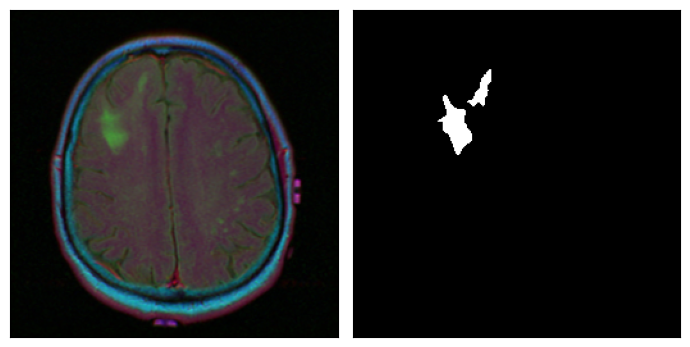

In [15]:
import cv2
image = cv2.imread(images_df['MRI_image'][7])
mask = cv2.imread(images_df['MRI_mask'][7])

plot_pair(image,mask)

In [16]:
def istumor(mask_img):
    """
    Finding wheather the mask has tumor or not
    """
    mask_img = cv2.imread(mask_img)
    k = np.max(mask_img)
    return 1 if k>0 else 0

In [17]:
images_df["is_tumor"] = images_df['MRI_mask'].apply(istumor)

In [18]:
images_df.head()

,MRI_image,MRI_mask,is_tumor
0,E:\git_repos\Brain_Tum_segmentation\archive\ka...,E:\git_repos\Brain_Tum_segmentation\archive\ka...,0
1,E:\git_repos\Brain_Tum_segmentation\archive\ka...,E:\git_repos\Brain_Tum_segmentation\archive\ka...,1
2,E:\git_repos\Brain_Tum_segmentation\archive\ka...,E:\git_repos\Brain_Tum_segmentation\archive\ka...,1
3,E:\git_repos\Brain_Tum_segmentation\archive\ka...,E:\git_repos\Brain_Tum_segmentation\archive\ka...,1
4,E:\git_repos\Brain_Tum_segmentation\archive\ka...,E:\git_repos\Brain_Tum_segmentation\archive\ka...,1


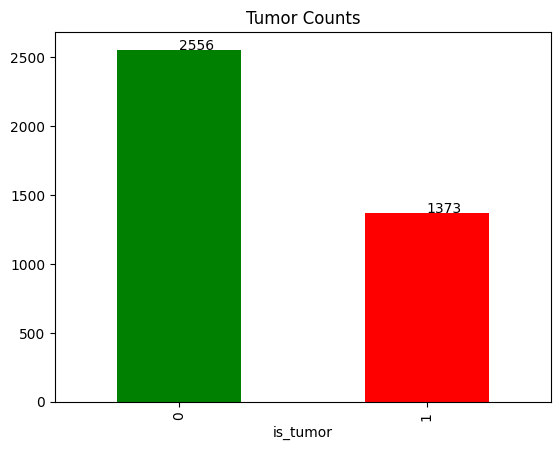

In [22]:
ax = images_df["is_tumor"].value_counts().plot(kind="bar", title="Tumor Counts", color=['g', 'r'])

for patch in ax.patches:
    ax.annotate(text=str(patch.get_height()), xy=(patch.get_x() + 0.25, patch.get_height() + 0.5))

plt.show()


In [23]:
print("Percentage of patients with no tumor", str( (images_df["is_tumor"].value_counts()[0]/ images_df["is_tumor"].value_counts().sum() ) *100) )
print("Percentage of patients with  tumor", str( (images_df["is_tumor"].value_counts()[1]/ images_df["is_tumor"].value_counts().sum() ) *100) )

Percentage of patients with no tumor 65.05472130313056
Percentage of patients with  tumor 34.94527869686943


In [24]:
print(patch)

Rectangle(xy=(0.75, 0), width=0.5, height=1373, angle=0)


In [25]:
no_tumor = images_df[images_df["is_tumor"] == 0 ].sample(3)
yes_tumor = images_df[images_df["is_tumor"] ==  1].sample(3)

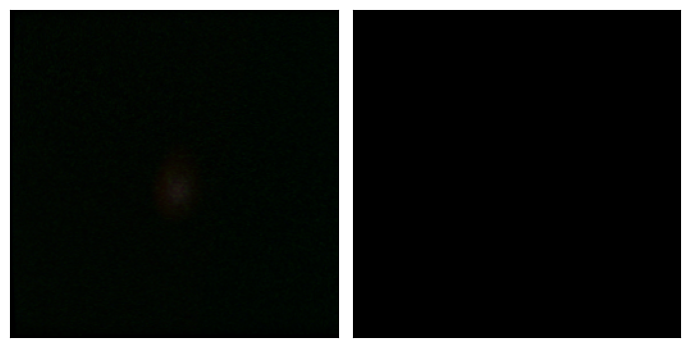

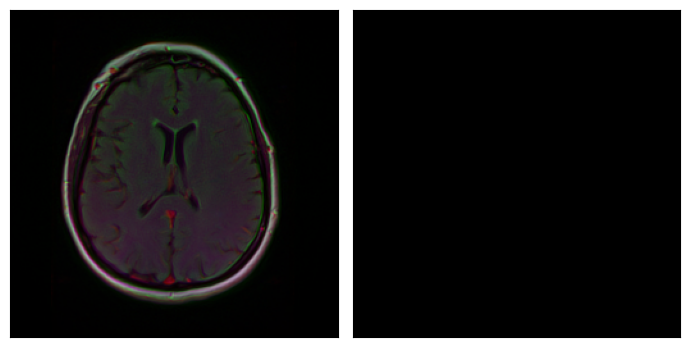

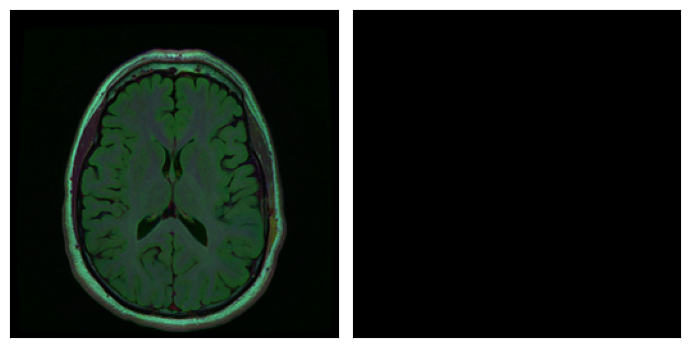

In [26]:
# Sample of no tumor 
for i in no_tumor.index:
    image = cv2.imread(no_tumor.loc[i]['MRI_image'])
    mask = cv2.imread(no_tumor.loc[i]['MRI_mask'])
    plot_pair(image,mask)

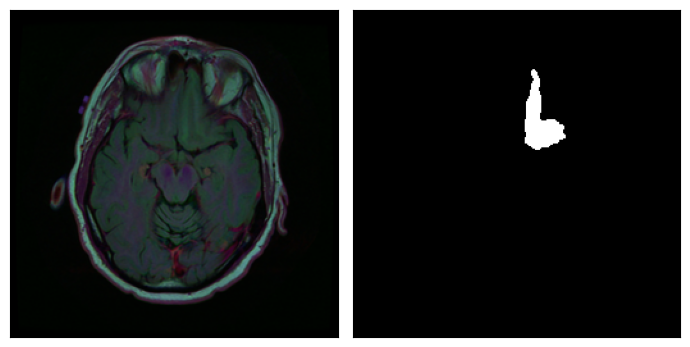

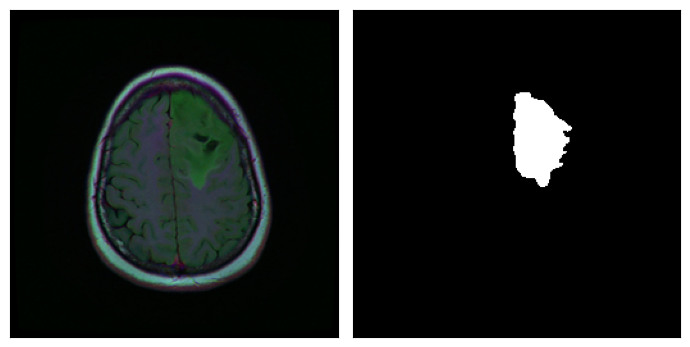

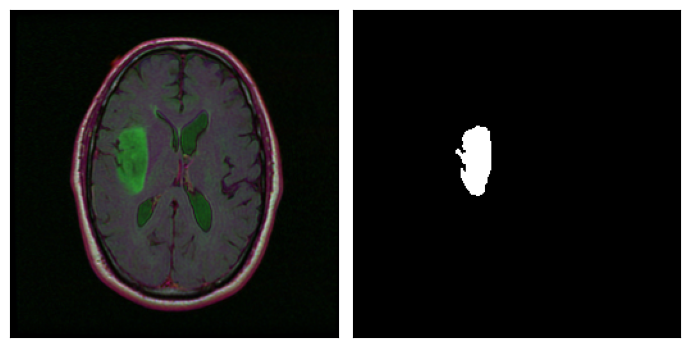

In [27]:
# Sample of  tumor images and mask
for i in yes_tumor.index:
    image = cv2.imread(yes_tumor.loc[i]['MRI_image'])
    mask = cv2.imread(yes_tumor.loc[i]['MRI_mask'])
    plot_pair(image,mask)

As 65% of patients have no tumor, it's reasonable to create a classification model to separate patients which are having tumors.

## Data augmentation



In [42]:
import cv2
image = cv2.imread(images_df['MRI_image'][7])
mask = cv2.imread(images_df['MRI_mask'][7])

'E:\\git_repos\\Brain_Tum_segmentation\\archive\\kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_17_flip.tif'

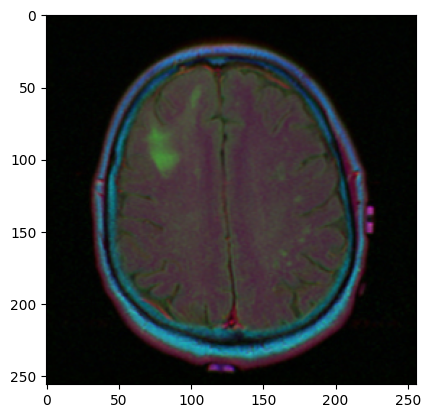

In [48]:
tiff_file = images_df['MRI_image'][7] # File path
I = cv2.imread(tiff_file)
tiff_file_mask = images_df['MRI_mask'][7] # File path
J = cv2.imread(tiff_file_mask)
plt.imshow(I)
tiff_file[:-4] + '_' + "flip" + '.tif'

(<matplotlib.image.AxesImage at 0x1a327fd30d0>, (256, 256, 3))

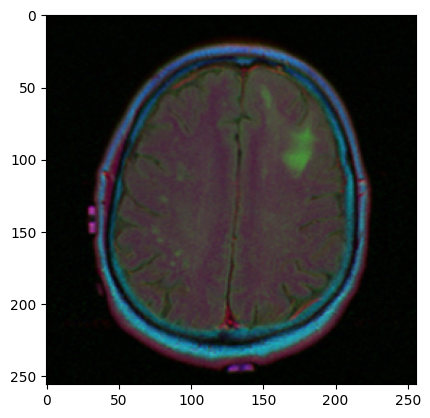

In [49]:
I = cv2.flip(I, flipCode= 1) # Flip value of 1 is for left to right flip
plt.imshow(I), I.shape

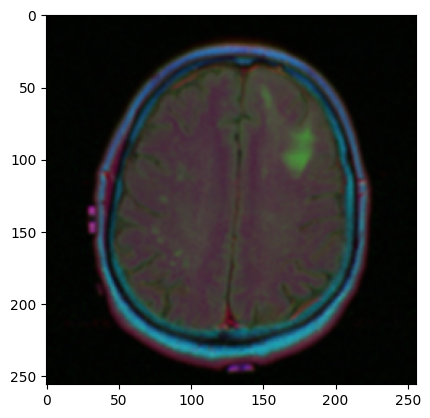

In [50]:
I = cv2.blur(I,(3,3)) # Blur operation will remove the sharpe edges in the image
plt.imshow(I)

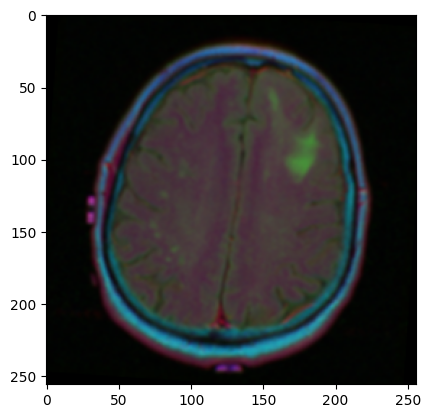

In [51]:
# Rotate Img by certain degrees
angle = np.random.randint(low= -20, high=20,)
w = 256
h = 256
M = cv2.getRotationMatrix2D((int(256/2), int(256/2)), angle,1)
I = cv2.warpAffine(I, M, (w, h))
plt.imshow(I)

(<matplotlib.image.AxesImage at 0x1a327ec4040>, (256, 256, 3))

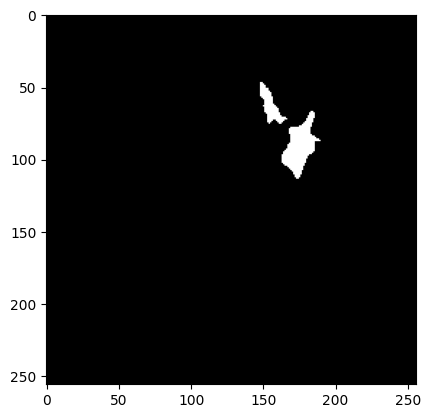

In [52]:
J = cv2.flip(J,flipCode= 1)
plt.imshow(J),J.shape

In [58]:
cv2.imwrite('image.tif', J)

True

In [59]:
abc = tiff_file[:-4] + '_' + "flip" + '.tif'  
abc = abc.replace(r'E:\git_repos\Brain_Tum_segmentation\archive\kaggle_3m', r'E:\git_repos\Brain_Tum_segmentation\archive\augmented_data')
abc

'E:\\git_repos\\Brain_Tum_segmentation\\archive\\augmented_data/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_17_flip.tif'

In [60]:
w = 256
h = 256
def image_augmentation(image_path, mask_path):
    """
    Takes the path of umage and mask and apply any one of the image augmentation and save the image

    """
    I = cv2.imread(image_path)
    J = cv2.imread(image_path)
    oper = np.random.randint(low= 1, high=3)
    if oper == 1:
        #Flip image and mask
        opertation = "flip"
        I = cv2.flip(I, flipCode= 1) # Flip value of 1 is for left to right flip
        J = cv2.flip(J, flipCode= 1)
    if oper == 2:

        # Rotate Image and mask by a random angle  between a range
        opertation = "rotate"
        angle = np.random.randint(low= -20, high=20,)
        M = cv2.getRotationMatrix2D((int(256/2), int(256/2)), angle,1)
        I = cv2.warpAffine(I, M, (w, h))
        J = cv2.warpAffine(J, M, (w, h))
    
    if oper == 3:
        # Blur operation will remove the sharpe edges in the image
        opertation = "blur"
        I = cv2.blur(I,(3,3)) 
        J = cv2.blur(J,(3,3))

    return_image = image_path[:-4] + '_' + opertation + '.tif'
    return_image = return_image.replace(r'E:\git_repos\Brain_Tum_segmentation\archive\kaggle_3m', r'E:\git_repos\Brain_Tum_segmentation\archive\augmented_data')
    dirname = os.path.dirname(return_image)
    if not os.path.exists(dirname):
        os.makedirs(dirname)

    return_mask_path = mask_path[:-4] + '_mask' + opertation + '.tif'
    return_mask_path = return_mask_path.replace(r'E:\git_repos\Brain_Tum_segmentation\archive\kaggle_3m', r'E:\git_repos\Brain_Tum_segmentation\archive\augmented_data')
    dirname = os.path.dirname(return_mask_path)
    if not os.path.exists(dirname):
        os.makedirs(dirname)


    #print(return_image, return_mask_path)


    if not cv2.imwrite(return_image, I):
        print("Image not saved")
    if not cv2.imwrite( return_mask_path, J):
        print("mask not saved")
    MRI_image_aug.append(return_image)
    MRI_mask_aug.append(return_mask_path)



In [61]:
not_tumor_count = images_df["is_tumor"].value_counts()[0]
tumor_count = images_df["is_tumor"].value_counts()[1]
not_tumor_count,tumor_count

(2556, 1373)

Lets add 100 augmented images of no tumor and 500 + diffence between(no tumor and tumor) augmented images of tumor for balancing the dataset.

In [64]:
number_augmented_image = 100
difference  = not_tumor_count - tumor_count
no_tumor = images_df[images_df["is_tumor"] == 0 ].sample(number_augmented_image)
yes_tumor = images_df[images_df["is_tumor"] ==  1].sample(number_augmented_image + difference)
no_tumor.shape , yes_tumor.shape

((100, 3), (1283, 3))

In [65]:
no_tumor.head()

,MRI_image,MRI_mask,is_tumor
2702,E:\git_repos\Brain_Tum_segmentation\archive\ka...,E:\git_repos\Brain_Tum_segmentation\archive\ka...,0
1390,E:\git_repos\Brain_Tum_segmentation\archive\ka...,E:\git_repos\Brain_Tum_segmentation\archive\ka...,0
2224,E:\git_repos\Brain_Tum_segmentation\archive\ka...,E:\git_repos\Brain_Tum_segmentation\archive\ka...,0
2435,E:\git_repos\Brain_Tum_segmentation\archive\ka...,E:\git_repos\Brain_Tum_segmentation\archive\ka...,0
1737,E:\git_repos\Brain_Tum_segmentation\archive\ka...,E:\git_repos\Brain_Tum_segmentation\archive\ka...,0


In [66]:
MRI_image_aug = []
MRI_mask_aug = []
for idx in no_tumor.index:
    image_path = no_tumor['MRI_image'][idx]
    mask_path = no_tumor['MRI_image'][idx]
    image_augmentation(image_path, mask_path)


In [67]:
for idx in yes_tumor.index:
    image_path = yes_tumor['MRI_image'][idx]
    mask_path = yes_tumor['MRI_image'][idx]
    image_augmentation(image_path, mask_path)

In [68]:
MRI_image_aug[0],MRI_mask_aug[0]

('E:\\git_repos\\Brain_Tum_segmentation\\archive\\augmented_data/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_2_rotate.tif',
 'E:\\git_repos\\Brain_Tum_segmentation\\archive\\augmented_data/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_2_maskrotate.tif')

In [69]:
len(MRI_image_aug),len(MRI_mask_aug),

(1383, 1383)

In [70]:
# Checking is all the images are proper files or not
for file in MRI_image_aug:
    if not  os.path.isfile(file):
        print("error")

for file in MRI_mask_aug:
    if not  os.path.isfile(file):
        print("error")

In [71]:
aug_images_df = pd.DataFrame(data = zip(MRI_image_aug,MRI_mask_aug),columns= ['MRI_image', 'MRI_mask'])
aug_images_df.head()

,MRI_image,MRI_mask
0,E:\git_repos\Brain_Tum_segmentation\archive\au...,E:\git_repos\Brain_Tum_segmentation\archive\au...
1,E:\git_repos\Brain_Tum_segmentation\archive\au...,E:\git_repos\Brain_Tum_segmentation\archive\au...
2,E:\git_repos\Brain_Tum_segmentation\archive\au...,E:\git_repos\Brain_Tum_segmentation\archive\au...
3,E:\git_repos\Brain_Tum_segmentation\archive\au...,E:\git_repos\Brain_Tum_segmentation\archive\au...
4,E:\git_repos\Brain_Tum_segmentation\archive\au...,E:\git_repos\Brain_Tum_segmentation\archive\au...


In [72]:
aug_images_df.shape

(1383, 2)

In [73]:
def istumor(mask_img):
    """
    Finding wheather the mask has tumor or not
    """
    mask_img = cv2.imread(mask_img)
    k = np.max(mask_img)
    return 1 if k>0 else 0

In [74]:
aug_images_df["is_tumor"] = aug_images_df['MRI_mask'].apply(istumor)

In [75]:
aug_images_df.head()

,MRI_image,MRI_mask,is_tumor
0,E:\git_repos\Brain_Tum_segmentation\archive\au...,E:\git_repos\Brain_Tum_segmentation\archive\au...,1
1,E:\git_repos\Brain_Tum_segmentation\archive\au...,E:\git_repos\Brain_Tum_segmentation\archive\au...,1
2,E:\git_repos\Brain_Tum_segmentation\archive\au...,E:\git_repos\Brain_Tum_segmentation\archive\au...,1
3,E:\git_repos\Brain_Tum_segmentation\archive\au...,E:\git_repos\Brain_Tum_segmentation\archive\au...,1
4,E:\git_repos\Brain_Tum_segmentation\archive\au...,E:\git_repos\Brain_Tum_segmentation\archive\au...,1


In [76]:
# combining both the augmented and original dataset
total_df = pd.concat([images_df,aug_images_df], ignore_index= True)
total_df.head(),total_df.shape

(                                           MRI_image  \
 0  E:\git_repos\Brain_Tum_segmentation\archive\ka...   
 1  E:\git_repos\Brain_Tum_segmentation\archive\ka...   
 2  E:\git_repos\Brain_Tum_segmentation\archive\ka...   
 3  E:\git_repos\Brain_Tum_segmentation\archive\ka...   
 4  E:\git_repos\Brain_Tum_segmentation\archive\ka...   
 
                                             MRI_mask  is_tumor  
 0  E:\git_repos\Brain_Tum_segmentation\archive\ka...         0  
 1  E:\git_repos\Brain_Tum_segmentation\archive\ka...         1  
 2  E:\git_repos\Brain_Tum_segmentation\archive\ka...         1  
 3  E:\git_repos\Brain_Tum_segmentation\archive\ka...         1  
 4  E:\git_repos\Brain_Tum_segmentation\archive\ka...         1  ,
 (5312, 3))

### Distributing after augmentation.

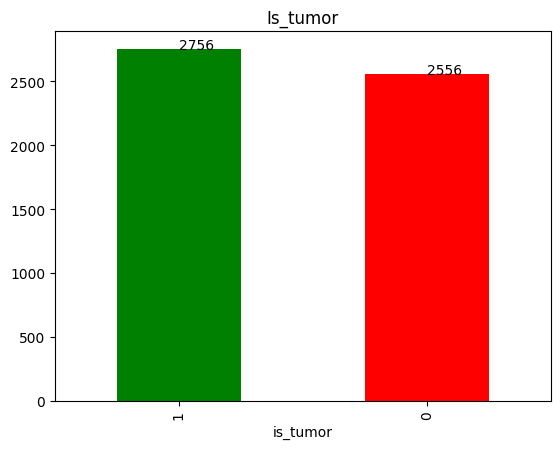

In [82]:
ax = total_df["is_tumor"].value_counts().plot(kind="bar", title="Is_tumor", color=['g', 'r'])

for patch in ax.patches:
    ax.annotate(text=str(patch.get_height()), xy=(patch.get_x() + 0.25, patch.get_height() + 0.5))

plt.show()


In [83]:
print("Percentage of patients with no tumor", str( (total_df["is_tumor"].value_counts()[0]/ total_df["is_tumor"].value_counts().sum() ) *100) )
print("Percentage of patients with  tumor", str( (total_df["is_tumor"].value_counts()[1]/ total_df["is_tumor"].value_counts().sum() ) *100) )

Percentage of patients with no tumor 48.11746987951807
Percentage of patients with  tumor 51.88253012048193


Dataset is now almost evenly balanced

## Classification into tumor or not

Using a different model to create a classifier inot tumor and non tumor.

In [84]:
total_df['is_tumor']= total_df['is_tumor'].astype(str)

In [85]:
train_df , test_df = train_test_split(total_df[['MRI_image','is_tumor']],stratify = total_df['is_tumor'], test_size = 0.2 )

In [86]:
train_df.shape, test_df.shape

((4249, 2), (1063, 2))

In [87]:
train_df.head(), train_df.shape

(                                              MRI_image is_tumor
 4192  E:\git_repos\Brain_Tum_segmentation\archive\au...        1
 1803  E:\git_repos\Brain_Tum_segmentation\archive\ka...        0
 3932  E:\git_repos\Brain_Tum_segmentation\archive\au...        1
 4963  E:\git_repos\Brain_Tum_segmentation\archive\au...        1
 1833  E:\git_repos\Brain_Tum_segmentation\archive\ka...        0,
 (4249, 2))

In [88]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
BATCH_SIZE = 16

datagen = ImageDataGenerator(rescale=1./255., validation_split = 0.15)
                             #horizontal_flip=True,brightness_range=(-0.1,0.1),
                            

In [89]:
# NOTE: change class mode to binary as default mode is categorical
train_datagenerator = datagen.flow_from_dataframe(
    dataframe= train_df,
    x_col='MRI_image',y_col= 'is_tumor',subset="training",
    target_size=(256,256),class_mode="binary",batch_size = BATCH_SIZE
)

val_datagenerator = datagen.flow_from_dataframe(
    dataframe= train_df,
    x_col='MRI_image',y_col= 'is_tumor',subset="validation",
    target_size=(256,256),class_mode="binary",batch_size = BATCH_SIZE
)

test_datagenerator = datagen.flow_from_dataframe(
    dataframe= test_df,
    x_col='MRI_image',y_col= 'is_tumor',
    target_size=(256,256),class_mode="binary",batch_size = BATCH_SIZE
)

Found 3612 validated image filenames belonging to 2 classes.
Found 637 validated image filenames belonging to 2 classes.
Found 1063 validated image filenames belonging to 2 classes.


In [90]:
next(train_datagenerator)[1].shape, next(train_datagenerator)[0].shape

((16,), (16, 256, 256, 3))

### Simple classifier


In [104]:
# Simple Classification using CNN

simple_classifier = tf.keras.models.Sequential()

simple_classifier.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', input_shape=[256, 256, 3]))
simple_classifier.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=1))

simple_classifier.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
simple_classifier.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=1))

simple_classifier.add(tf.keras.layers.Flatten())

simple_classifier.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))


In [105]:
simple_classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 253, 253, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 251, 251, 32)      18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 250, 250, 32)     0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 2000000)           0         
                                                                 
 dense (Dense)               (None, 1)                 2

In [106]:
tf.keras.backend.clear_session()

In [107]:
# EarlyStopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
#                                                           patience=5,verbose=1,
#                                                           min_delta = 0.00001)
# reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.01,
#                               patience=2,min_delta=0.01,verbose=1,
#                                min_lr=1e-12)

# log_dir = r"E:\git_repos\Brain_Tum_segmentation\logs\fit\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# #tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir= log_dir)

# optimizer = tf.keras.optimizers.Adam(learning_rate=0.001 ) # 0.001 deafault

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
simple_classifier.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Set up callbacks
EarlyStopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                          patience=5, verbose=1,
                                                          min_delta=0.00001)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.01,
                                                 patience=2, min_delta=0.01, verbose=1,
                                                 min_lr=1e-12)
log_dir = r"E:\git_repos\Brain_Tum_segmentation\logs\fit\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

# Train the model
simple_classifier.fit(train_datagenerator, validation_data=val_datagenerator,
                       callbacks=[EarlyStopping_callback, reduce_lr, tensorboard_callback],
                       epochs=20)

# Save the trained model
simple_classifier.save("E:\\git_repos\\Brain_Tum_segmentation\\simple_class_model.h5")


Epoch 1/20
226/226 [==============================] - 10s 41ms/step - loss: 0.6514 - accuracy: 0.6816 - val_loss: 0.5821 - val_accuracy: 0.7190 - lr: 0.0010
Epoch 2/20
226/226 [==============================] - 9s 41ms/step - loss: 0.4303 - accuracy: 0.8239 - val_loss: 0.4632 - val_accuracy: 0.7802 - lr: 0.0010
Epoch 3/20
226/226 [==============================] - 9s 41ms/step - loss: 0.3308 - accuracy: 0.8710 - val_loss: 0.4485 - val_accuracy: 0.8085 - lr: 0.0010
Epoch 4/20
226/226 [==============================] - 9s 40ms/step - loss: 0.2458 - accuracy: 0.9078 - val_loss: 0.4466 - val_accuracy: 0.8179 - lr: 0.0010
Epoch 5/20
225/226 [============================>.] - ETA: 0s - loss: 0.1712 - accuracy: 0.9355
Epoch 5: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
226/226 [==============================] - 10s 42ms/step - loss: 0.1710 - accuracy: 0.9355 - val_loss: 0.4528 - val_accuracy: 0.8352 - lr: 0.0010
Epoch 6/20
226/226 [==============================] - 10

### Classification using Xception

In [108]:
#convolution Block
def conv_bn(x, filters, kernel_size, strides=1):
    x = tf.keras.layers.Conv2D(filters=filters, 
               kernel_size = kernel_size, 
               strides=strides, 
               padding = 'same', 
               use_bias = False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    return x


# separableConv block

def sep_bn(x, filters, kernel_size, strides=1):
    x = tf.keras.layers.SeparableConv2D(filters=filters, 
                        kernel_size = kernel_size, 
                        strides=strides, 
                        padding = 'same', 
                        use_bias = False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    return x


# Entry Flow
def entry_flow(x):
    
    x = conv_bn(x, filters =32, kernel_size =3, strides=2)
    x = tf.keras.layers.ReLU()(x)
    x = conv_bn(x, filters =64, kernel_size =3, strides=1)
    tensor = tf.keras.layers.ReLU()(x)
    
    x = sep_bn(tensor, filters = 128, kernel_size =3)
    x = tf.keras.layers.ReLU()(x)
    x = sep_bn(x, filters = 128, kernel_size =3)
    x = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding = 'same')(x)
    
    tensor = conv_bn(tensor, filters=128, kernel_size = 1,strides=2)
    x = tf.keras.layers.Add()([tensor,x])
    
    x = tf.keras.layers.ReLU()(x)
    x = sep_bn(x, filters =256, kernel_size=3)
    x = tf.keras.layers.ReLU()(x)
    x = sep_bn(x, filters =256, kernel_size=3)
    x = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding = 'same')(x)
    
    tensor = conv_bn(tensor, filters=256, kernel_size = 1,strides=2)
    x = tf.keras.layers.Add()([tensor,x])
    
    x = tf.keras.layers.ReLU()(x)
    x = sep_bn(x, filters =728, kernel_size=3)
    x = tf.keras.layers.ReLU()(x)
    x = sep_bn(x, filters =728, kernel_size=3)
    x = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding = 'same')(x)
    
    tensor = conv_bn(tensor, filters=728, kernel_size = 1,strides=2)
    x = tf.keras.layers.Add()([tensor,x])
    return x

In [109]:
# Middle Flow
def middle_flow(tensor):
    for temp in range(8):
        x = tf.keras.layers.ReLU()(tensor)
        x = sep_bn(x, filters = 728, kernel_size = 3)
        x = tf.keras.layers.ReLU()(x)
        x = sep_bn(x, filters = 728, kernel_size = 3)
        x = tf.keras.layers.ReLU()(x)
        x = sep_bn(x, filters = 728, kernel_size = 3)
        x = tf.keras.layers.ReLU()(x)
        tensor = tf.keras.layers.Add()([tensor,x])
        
    return tensor


# Exit Flow
def exit_flow(tensor):
    
    x = tf.keras.layers.ReLU()(tensor)
    x = sep_bn(x, filters = 728,  kernel_size=3)
    x = tf.keras.layers.ReLU()(x)
    x = sep_bn(x, filters = 1024,  kernel_size=3)
    x = tf.keras.layers.MaxPool2D(pool_size = 3, strides = 2, padding ='same')(x)
    
    tensor = conv_bn(tensor, filters =1024, kernel_size=1, strides =2)
    x = tf.keras.layers.Add()([tensor,x])
    
    x = sep_bn(x, filters = 1536,  kernel_size=3)
    x = tf.keras.layers.ReLU()(x)
    x = sep_bn(x, filters = 2048,  kernel_size=3)
    x = tf.keras.layers.GlobalAvgPool2D()(x)

    # custom layers
    """
    x = tf.keras.layers.Dense(1024, activation='relu', kernel_initializer='he_normal', name='dense_layer_1')(x)
    x = tf.keras.layers.BatchNormalization(name='bn_layer_1')(x)
    x = tf.keras.layers.Dropout(0.4, name='dropout_layer_1')(x)
    """

    x = tf.keras.layers.Dense(512, activation='relu', kernel_initializer='he_normal', name='dense_layer_21')(x)
    x = tf.keras.layers.BatchNormalization(name='bn_layer_2')(x)
    x = tf.keras.layers.Dropout(0.4, name='dropout_layer_2')(x)

    x = tf.keras.layers.Dense(64, activation='relu', kernel_initializer='he_normal', name='dense_layer_22')(x)
    x = tf.keras.layers.Dense(1, activation='sigmoid', name='predictions')(x)
    
    return x

In [110]:
input = tf.keras.layers.Input(shape = (256,256,3))
x= entry_flow(input)
x = middle_flow(x)
output = exit_flow(x)

xception_model = tf.keras.Model(inputs=input, outputs=output)
xception_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [111]:
tf.keras.backend.clear_session()

In [112]:
EarlyStopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                          patience=4,verbose=1,
                                                          min_delta = 0.00001)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2,min_delta=0.02,verbose=1,
                               min_lr=1e-12)

log_dir = r"E:\git_repos\Brain_Tum_segmentation\logs1\fit\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir= log_dir)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001 ) # 0.001 deafault

xception_model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

# Train the model
xception_model.fit(train_datagenerator, validation_data=val_datagenerator,
                       callbacks=[EarlyStopping_callback, reduce_lr, tensorboard_callback],
                       epochs=20)

# Save the trained model
xception_model.save("E:\\git_repos\\Brain_Tum_segmentation\\xception_class_model.h5")

Epoch 1/20
226/226 [==============================] - 47s 175ms/step - loss: 0.6090 - accuracy: 0.7021 - val_loss: 0.7272 - val_accuracy: 0.4553 - lr: 1.0000e-04
Epoch 2/20
226/226 [==============================] - 40s 178ms/step - loss: 0.4988 - accuracy: 0.7757 - val_loss: 0.7435 - val_accuracy: 0.4553 - lr: 1.0000e-04
Epoch 3/20
226/226 [==============================] - ETA: 0s - loss: 0.3982 - accuracy: 0.8333
Epoch 3: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
226/226 [==============================] - 38s 166ms/step - loss: 0.3982 - accuracy: 0.8333 - val_loss: 0.8094 - val_accuracy: 0.5950 - lr: 1.0000e-04
Epoch 4/20
226/226 [==============================] - 37s 166ms/step - loss: 0.2074 - accuracy: 0.9181 - val_loss: 0.3573 - val_accuracy: 0.8524 - lr: 1.0000e-05
Epoch 5/20
226/226 [==============================] - 39s 171ms/step - loss: 0.1244 - accuracy: 0.9601 - val_loss: 0.3527 - val_accuracy: 0.8634 - lr: 1.0000e-05
Epoch 6/20
226/226 [=========

Classification Model using Xception model has achieved a validation accuracy of 87%

## Segmentation

Segmentation model trained using only the Images that have only tumor images

In [113]:
#Data for segmentation
#tumor_df  = images_df[images_df["is_tumor"] == '1']
tumor_df  = images_df[images_df["is_tumor"] == 1]
tumor_df.shape

(1373, 3)

In [114]:
X_train,X_val = train_test_split(tumor_df, test_size=0.2)
X_test,X_val = train_test_split(tumor_df, test_size=0.5)

print("Train data shape", X_train.shape)
print("Test data shape", X_test.shape)
print("Validation data shape", X_val.shape)

Train data shape (1098, 3)
Test data shape (686, 3)
Validation data shape (687, 3)


In [115]:
np.arange(5)

array([0, 1, 2, 3, 4])

#### Datagenerator Class

In [116]:
# Custom DataGernerator class

class Datagenerator(tf.keras.utils.Sequence):
    def __init__(self,df, X_col,Y_col ,img_h , img_w ,batch_size = 16, shuffle = True):
        self.batch_size = batch_size
        self.df = df
        self.n = len(self.df)

        self.X_col = X_col
        self.Y_col = Y_col
        self.img_h = img_h
        self.img_w = img_w
        self.shuffle = shuffle
        self.on_epoch_end()


    def __len__(self):
        """
        It is returns the number of batches .
        Complusory method
        """
        return int( self.n/self.batch_size)

    
    def __getitem__(self, index):
        """
        Returns a batch of input image and its respective mask.
        """
        # Getting indices of length batcg size
        indices = self.indices[ index * self.batch_size : (index +1) * self.batch_size]

        X,Y = self.__data_generation(indices)

        return X,Y


    def on_epoch_end(self):
        """
        Shuffling indices after each epoch
        """
        self.indices = np.array(self.df.index) #np.arange(self.n)

        if self.shuffle:
            #self.indices = np.random.permutation( self.indices )
            np.random.shuffle(self.indices)

    def __data_generation(self,indices):
        """
        Return a single batch of (X,Y) of images and there segmentation mask
        with preprocessing applied.

        """
        X = np.empty((self.batch_size,self.img_h,self.img_w, 3 )) # input is 3 channel
        Y = np.empty((self.batch_size,self.img_h,self.img_w, 1 )) # mask is 1 channel

        for i in range(self.batch_size):
            idx = indices[i]
            img_path = str(self.df.loc[idx]['MRI_image'])

            mask_path = str(self.df.loc[idx]['MRI_mask'])

            img = io.imread(img_path)
            mask = io.imread(mask_path)

            # resize img and convert to array
            img = cv2.resize(img,(self.img_h, self.img_w))
            img = np.array(img, dtype = np.float64)

            # resize mask and convert to array
            mask = cv2.resize(mask,(self.img_h, self.img_w))
            mask = np.array(mask, dtype = np.float64)

            #standardising , This has improved the performance of model and images are better visible
            img -= img.mean()
            img /= img.std()

            mask -= mask.mean()
            mask /= mask.std()

            #print(i)
            #print(img.shape,mask.shape)

            X[i,] = img

            Y[i,] = np.expand_dims(mask,axis = 2)

        Y = (Y > 0).astype(int)
        #print(X.shape,Y.shape)

        
        return X,Y



In [117]:
np.array(X_train.index)

array([ 444, 1893, 1960, ...,  125, 2747, 1362], dtype=int64)

In [118]:
idx = X_train.index[58]

In [119]:
img_h = 256
img_w = 256
img_path = str(X_train.loc[idx]['MRI_image'])

mask_path = str(X_train.loc[idx]['MRI_mask'])

img = io.imread(img_path)
mask = io.imread(mask_path)

# resize img and convert to array
img = cv2.resize(img,(img_h, img_w))
img = np.array(img, dtype = np.float64)

#resize mask and convert to array
mask = cv2.resize(mask,(img_h,img_w))
mask = np.array(mask, dtype = np.float64)

#standardising 
img -= img.mean()
img /= img.std()

mask -= mask.mean()
mask /= mask.std()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


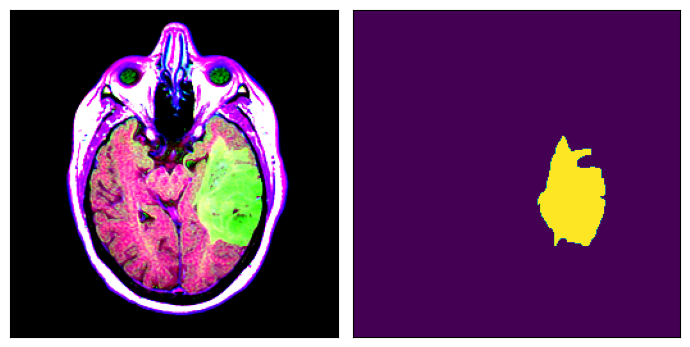

In [120]:
plot_pair(img,mask)

In [124]:
print(X_train.index.min(), X_train.index.max())
X_train.iloc[1]

1 3882


MRI_image    E:\git_repos\Brain_Tum_segmentation\archive\ka...
MRI_mask     E:\git_repos\Brain_Tum_segmentation\archive\ka...
is_tumor                                                     1
Name: 1893, dtype: object

In [125]:
train_data = Datagenerator(df = X_train ,X_col= "MRI_image", Y_col="MRI_mask",img_h = 256 , img_w = 256 )
val_data = Datagenerator(df = X_val ,X_col= "MRI_image", Y_col="MRI_mask",img_h = 256 , img_w = 256 )

In [126]:
train_data.__getitem__(4)[0].shape, train_data.__getitem__(4)[1].shape

((16, 256, 256, 3), (16, 256, 256, 1))

In [127]:
path = r'E:\git_repos\Brain_Tum_segmentation\archive\kaggle_3m\TCGA_DU_A5TS_19970726\TCGA_DU_A5TS_19970726_22.tif'
image = tf.keras.preprocessing.image.load_img(path)
image_arr = tf.keras.preprocessing.image.img_to_array(image)

#### Focal tversky loss to tackle class imbalance

ref: https://towardsdatascience.com/dealing-with-class-imbalanced-image-datasets-1cbd17de76b5

![](https://imgur.com/3Fz3Q0l.png)


By setting α >  𝜷 it penalizes FN more

The Focal Tversky Loss (FTL) is a generalisation of the tversky loss. The non-linear nature of the loss gives you control over how the loss behaves at different values of the tversky index obtained.




Best parameter will need some try and error.


Default paramenter that works as good starting point.


α = 0.7, 𝜷 = 0.3, γ = 3/4

### Unet model

In [128]:
from keras.losses import binary_crossentropy
import keras.backend as K
import tensorflow as tf

smooth=1e-6

def tversky(y_true, y_pred):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

def focal_tversky(y_true,y_pred):
    y_true = tf.cast(y_true,tf.float32)
    y_pred = tf.cast(y_pred,tf.float32)
    #pt_1 = tversky(y_true, y_pred)
    #print(pt_1)
    gamma = 0.75
    return K.pow((1-tversky(y_true, y_pred)), gamma)


In [129]:
def resblock(X,filters):

    X_side = X
    X = tf.keras.layers.Conv2D(filters, kernel_size = (1,1))(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Activation("relu")(X)

    #padding='valid' is default
    X = tf.keras.layers.Conv2D(filters,padding='same', kernel_size = (3,3))(X)
    X = tf.keras.layers.BatchNormalization()(X)

    #side path
    X_side = tf.keras.layers.Conv2D(filters, kernel_size = (1,1))(X_side)
    X_side = tf.keras.layers.BatchNormalization()(X_side)

    # Adding both the path

    X = tf.keras.layers.Add()([X, X_side])
    X = tf.keras.layers.Activation("relu")(X)

    return X


def upsample(X,X_side):
    """
    Upsampling and concatination with the side path
    """

    X = tf.keras.layers.UpSampling2D((2,2))(X)
    concat = tf.keras.layers.Concatenate()([X,X_side])
    return concat

In [130]:
input_shape = (256,256,3)

input = tf.keras.Input(input_shape)

#Stage1
conv_1 = tf.keras.layers.Conv2D(16,padding='same', activation='relu', kernel_size = (3,3))(input)
conv_1 = tf.keras.layers.BatchNormalization()(conv_1)

conv_1 = tf.keras.layers.Conv2D(16,padding='same', activation='relu', kernel_size = (3,3))(conv_1)
conv_1 = tf.keras.layers.BatchNormalization()(conv_1)
pool_1 = tf.keras.layers.MaxPool2D((2,2))(conv_1)

#stage2
stage_2 = resblock(pool_1,32)
pool_2 = tf.keras.layers.MaxPool2D((2,2))(stage_2)

#stage3
stage_3 = resblock(pool_2,64)
pool_3 = tf.keras.layers.MaxPool2D((2,2))(stage_3)

#stage2
stage_4 = resblock(pool_3,128)
pool_4 = tf.keras.layers.MaxPool2D((2,2))(stage_4)


#bottle neck 
stage_5 = resblock(pool_4,256)


#upstage
print("stage_4 and stage_5" , stage_4.shape,stage_5.shape)

up_stage_1 = upsample(stage_5,stage_4)
#print(up_stage_1.shape)
up_stage_1 = resblock(up_stage_1,128)

print("up_stage_1 and stage_3" , up_stage_1.shape,stage_3.shape)

up_stage_2 = upsample(up_stage_1,stage_3)
up_stage_2 = resblock(up_stage_2,64)

print("up_stage_2 and stage_2" , up_stage_2.shape,stage_2.shape)

up_stage_3 = upsample(up_stage_2,stage_2)
up_stage_3 = resblock(up_stage_3,32)

print("up_stage_3 and conv_1" , up_stage_1.shape,conv_1.shape)
up_stage_4 = upsample(up_stage_3,conv_1)
up_stage_4 = resblock(up_stage_4,16)


output = tf.keras.layers.Conv2D(1,padding='same', activation='sigmoid', kernel_size = (1,1))(up_stage_4)
print(output.shape)


stage_4 and stage_5 (None, 32, 32, 128) (None, 16, 16, 256)
up_stage_1 and stage_3 (None, 32, 32, 128) (None, 64, 64, 64)
up_stage_2 and stage_2 (None, 64, 64, 64) (None, 128, 128, 32)
up_stage_3 and conv_1 (None, 32, 32, 128) (None, 256, 256, 16)
(None, 256, 256, 1)


In [131]:
segmentation_model = tf.keras.Model(input,output)
segmentation_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [132]:
tf.keras.backend.clear_session()

In [133]:
EarlyStopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                          patience=10,verbose=1,
                                                          min_delta = 0.00001) # Reduce patience to 7
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.01,
                              patience=5,min_delta=0.01,verbose=1,
                               min_lr=1e-12)

log_dir = r"E:\git_repos\Brain_Tum_segmentation\logs1\fit\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir= log_dir)


check_point = tf.keras.callbacks.ModelCheckpoint('Segmentation_Unet.hdf5', monitor='val_loss', verbose=1, save_best_only=True )

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01 ) # 0.001 deafault

In [134]:
# Train the model

segmentation_model.compile(optimizer = optimizer, 
                  loss = focal_tversky, 
                  metrics = [tversky]
                 )

In [135]:
model_hist = segmentation_model.fit(train_data, validation_data = val_data,
          callbacks= [EarlyStopping_callback,check_point,reduce_lr,tensorboard_callback ],epochs = 50)

Epoch 1/50
68/68 [==============================] - ETA: 0s - loss: 0.6028 - tversky: 0.4835
Epoch 1: val_loss improved from inf to 0.75721, saving model to Segmentation_Unet.hdf5
68/68 [==============================] - 20s 215ms/step - loss: 0.6028 - tversky: 0.4835 - val_loss: 0.7572 - val_tversky: 0.3092 - lr: 0.0100
Epoch 2/50
68/68 [==============================] - ETA: 0s - loss: 0.4360 - tversky: 0.6668
Epoch 2: val_loss did not improve from 0.75721
68/68 [==============================] - 14s 200ms/step - loss: 0.4360 - tversky: 0.6668 - val_loss: 0.9263 - val_tversky: 0.0969 - lr: 0.0100
Epoch 3/50
68/68 [==============================] - ETA: 0s - loss: 0.3894 - tversky: 0.7137
Epoch 3: val_loss did not improve from 0.75721
68/68 [==============================] - 13s 197ms/step - loss: 0.3894 - tversky: 0.7137 - val_loss: 0.8605 - val_tversky: 0.1812 - lr: 0.0100
Epoch 4/50
68/68 [==============================] - ETA: 0s - loss: 0.3652 - tversky: 0.7370
Epoch 4: val_loss 

There seems to be overfitting at the start of training the model.

But towards the end the difference between train and validation tversky accuracy i not much.

In [136]:
model_hist.history.keys()

dict_keys(['loss', 'tversky', 'val_loss', 'val_tversky', 'lr'])

In [137]:
# Save the trained model
segmentation_model.save("E:\\git_repos\\Brain_Tum_segmentation\\segmentation_model.h5")

segmentation_model_save = segmentation_model.to_json()

with open("E:\\git_repos\\Brain_Tum_segmentation\\segmentation_model_best.json", "w") as json_file:
    json_file.write(segmentation_model_save)

### Plotting performance of model

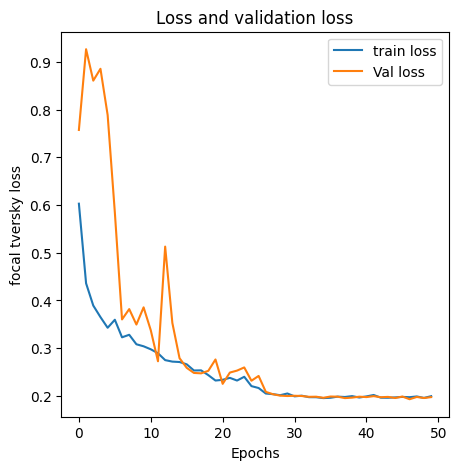

In [138]:
plt.figure(figsize=(5,5))
plt.title("Loss and validation loss")
plt.xlabel("Epochs")
plt.ylabel("focal tversky loss")
plt.plot(model_hist.history['loss'])
plt.plot(model_hist.history['val_loss'])
plt.legend(['train loss','Val loss'])

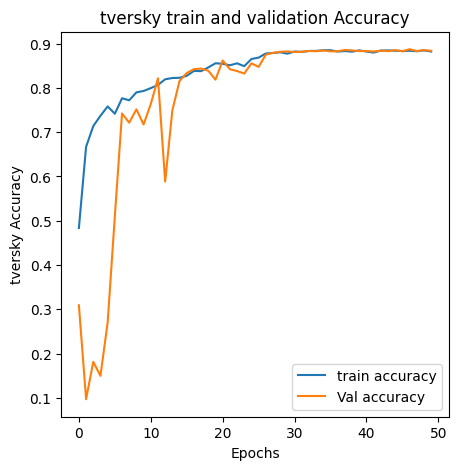

In [139]:
plt.figure(figsize=(5,5))
plt.title("tversky train and validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("tversky Accuracy")
plt.plot(model_hist.history['tversky'])
plt.plot(model_hist.history['val_tversky'])
plt.legend(['train accuracy','Val accuracy'])

In [140]:
test_data =  Datagenerator(df = X_test ,X_col= "MRI_image", Y_col="MRI_mask",img_h = 256 , img_w = 256 )


In [141]:
segmentation_model.evaluate(test_data)

42/42 [==============================] - 5s 123ms/step - loss: 0.1901 - tversky: 0.8896


[0.1901179552078247, 0.889576256275177]

In [142]:
predictions = segmentation_model.predict(test_data)

42/42 [==============================] - 6s 121ms/step


In [143]:
predictions

array([[[[3.47557557e-06],
         [3.89402931e-06],
         [4.15692466e-06],
         ...,
         [3.72888962e-06],
         [3.29419822e-06],
         [4.67030941e-06]],

        [[2.40159761e-06],
         [6.49535082e-07],
         [5.16364310e-07],
         ...,
         [5.23199901e-07],
         [2.71550653e-06],
         [3.39290864e-06]],

        [[3.44912064e-06],
         [7.58644319e-07],
         [7.02466934e-07],
         ...,
         [7.08307994e-07],
         [4.19539720e-06],
         [4.30464706e-06]],

        ...,

        [[4.13183943e-06],
         [7.82388213e-07],
         [6.59316527e-07],
         ...,
         [6.70842212e-07],
         [3.91829462e-06],
         [3.31091951e-06]],

        [[3.46887009e-06],
         [2.08599181e-06],
         [3.29666545e-06],
         ...,
         [3.03378033e-06],
         [4.60676893e-06],
         [2.27750274e-06]],

        [[1.63248410e-06],
         [1.91273580e-06],
         [1.98805787e-06],
         ...,
 

#### Prediction of segmentation mask


In [144]:
X_test.head()

,MRI_image,MRI_mask,is_tumor
1995,E:\git_repos\Brain_Tum_segmentation\archive\ka...,E:\git_repos\Brain_Tum_segmentation\archive\ka...,1
3691,E:\git_repos\Brain_Tum_segmentation\archive\ka...,E:\git_repos\Brain_Tum_segmentation\archive\ka...,1
635,E:\git_repos\Brain_Tum_segmentation\archive\ka...,E:\git_repos\Brain_Tum_segmentation\archive\ka...,1
1503,E:\git_repos\Brain_Tum_segmentation\archive\ka...,E:\git_repos\Brain_Tum_segmentation\archive\ka...,1
3306,E:\git_repos\Brain_Tum_segmentation\archive\ka...,E:\git_repos\Brain_Tum_segmentation\archive\ka...,1


In [145]:
ind = X_test.index
X_test.loc[ind[0]]['MRI_image']

'E:\\git_repos\\Brain_Tum_segmentation\\archive\\kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_25.tif'

In [146]:
def predict_segmentation_mask(image_path):
    # reads an brain MRI image
    img = io.imread(image_path)
    img = cv2.resize(img,(256,256))
    img = np.array(img, dtype=np.float64)
    img -= img.mean()
    img /= img.std()
    #img = np.reshape(img, (1,256,256,3) # this is the shape our model expects
    X = np.empty((1,256,256,3))
    X[0,] = img
    predict = segmentation_model.predict(X)

    return predict.reshape(256,256)



In [147]:
image_path = X_test.loc[ind[5]]['MRI_image']
original_mask = X_test.loc[ind[5]]['MRI_mask']
original_mask = cv2.imread(original_mask)
predicted_mask = predict_segmentation_mask(image_path)

1/1 [==============================] - 1s 748ms/step


In [148]:
def plot_mask_pair(original_mask,predicted_mask):
    """
    Inputs: image and mask 
    Outputs: plot both image and plot side by side
    """
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7, 5))
    axes[0].imshow(original_mask)
    axes[0].get_xaxis().set_visible(False)
    axes[0].get_yaxis().set_visible(False)
    axes[1].imshow(predicted_mask)
    axes[1].get_xaxis().set_visible(False)
    axes[1].get_yaxis().set_visible(False)
    fig.tight_layout()

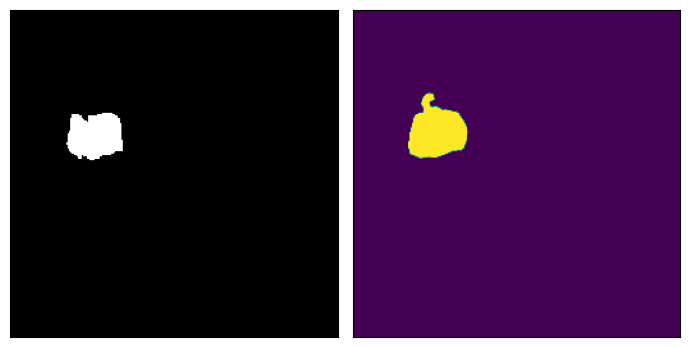

In [149]:
plot_mask_pair(original_mask,predicted_mask)

Some sample predictions

1/1 [==============================] - 0s 30ms/step


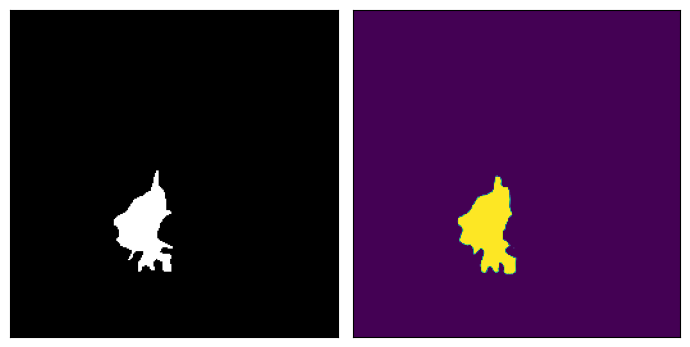

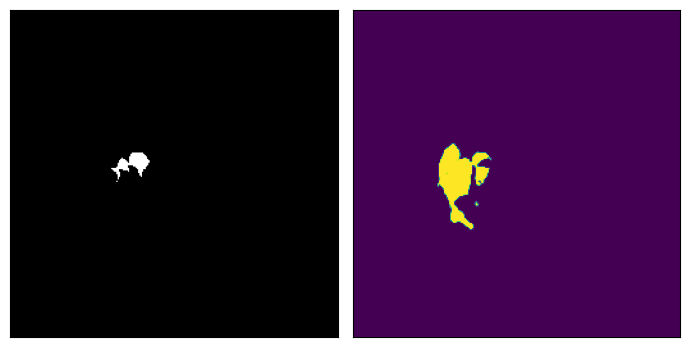

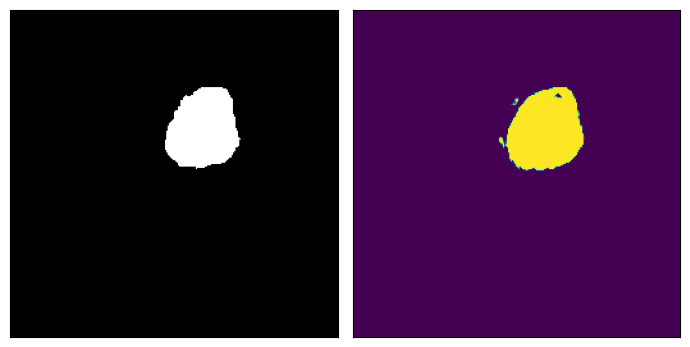

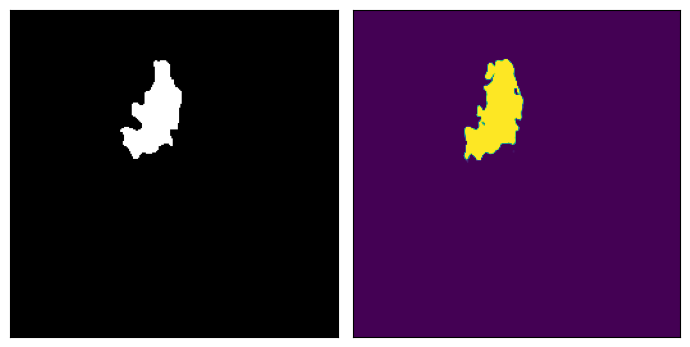

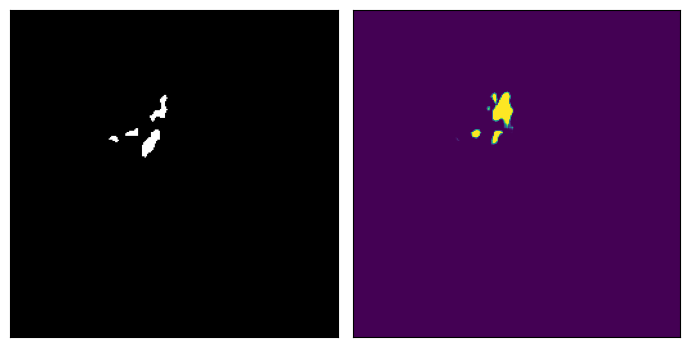

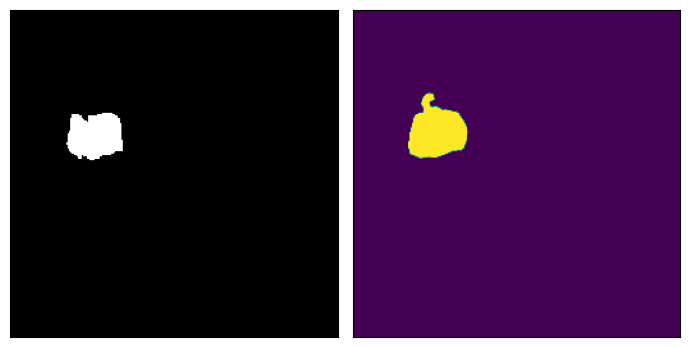

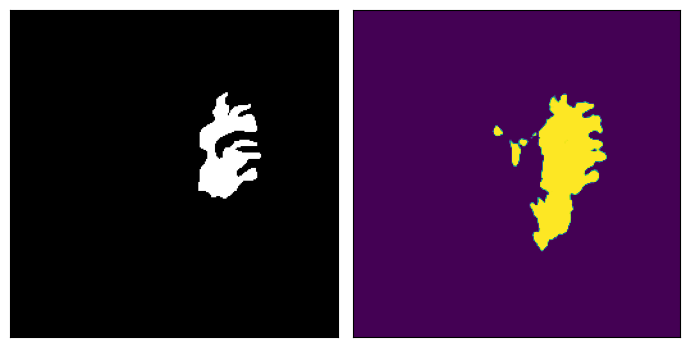

In [150]:
for i in range(7):
    image_path = X_test.loc[ind[i]]['MRI_image']
    original_mask = X_test.loc[ind[i]]['MRI_mask']
    original_mask = cv2.imread(original_mask)
    predicted_mask = predict_segmentation_mask(image_path)
    plot_mask_pair(original_mask,predicted_mask)
